In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import beta
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from selfpeptide.model.binding_affinity_classifier import Peptide_HLA_BindingClassifier
from selfpeptide.model.components import ResMLP_Network
from selfpeptide.utils.data_utils import load_immunogenicity_dataframes, filter_peptide_dataset, load_immunogenicity_dataframes_jointseqs, BetaDistributionDataset
from selfpeptide.utils.constants import *

from scipy import spatial

In [2]:
with open("../trained_models/BindingModels/floral-sweep-3/config.json", "r") as f:
    binding_config = json.load(f)
for k in binding_config.keys():
    if not isinstance(binding_config[k], str):
        continue
    if "/home/gvisona/SelfPeptides" in binding_config[k]:
        binding_config[k] = binding_config[k].replace("/home/gvisona/SelfPeptides", "/home/gvisona/Projects/SelfPeptides")
    if "/fast/gvisona/SelfPeptides" in binding_config[k]:
        binding_config[k] = binding_config[k].replace("/fast/gvisona/SelfPeptides", "/home/gvisona/Projects/SelfPeptides")
binding_config

{'PMA_ln': True,
 'PMA_num_heads': 4,
 'accumulate_batches': 64,
 'batch_size': 16,
 'binding_affinity_df': '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv',
 'cool_down': 0.8,
 'dropout_p': 0.05,
 'early_stopping': True,
 'embedding_dim': 512,
 'experiment_group': 'Binding_affinity_training_LS_joint',
 'experiment_name': 'Binding_model_LS_joint_seeds',
 'hla_embedding_dim': 1024,
 'hla_prot_seq_file': '/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv',
 'joint_embedder_hidden_dim': 2048,
 'ligand_atlas_binding_df': '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/HLA_Ligand_Atlas_processed.csv',
 'lr': 0.00030967294546198955,
 'ls_alpha': 0.05,
 'max_updates': 20000,
 'min_frac': 0.1,
 'mlp_hidden_dim': 2048,
 'mlp_input_dim': 512,
 'mlp_num_layers': 2,
 'momentum': 0.9,
 'n_attention_layers': 2,
 'nesterov_momentum': True,
 'num_heads': 4,
 'output_dim': 

In [3]:
imm_config = {}
config = {}
config["immunogenicity_df"] = "/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/Processed_TCell_IEDB_beta_summed.csv"
config["pseudo_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseq_mapping.csv"
config["hla_prot_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv"
config["binding_affinity_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv'
config["binding_model_checkpoint"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/checkpoints/001_checkpoint.pt'
config["binding_model_config"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/config.json'
config["dhlap_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/DHLAP_immunogenicity_data.csv'
config["test_size"] = 0.15
config["val_size"] = 0.1
config["seed"]= 0


In [4]:
iedb_df, dhlap_imm_df = load_immunogenicity_dataframes_jointseqs(config, False)
iedb_df

,Peptide,HLA,Qualitative Measurement,Peptide length,Number of Subjects Tested,Number of Subjects Positive,Alpha,Beta,Allele Pseudo-sequence,Allele Protein sequence,Target,Sample,Peptide Length,Distr. Mean,Distr. Variance,Distr. Mode,Distr. Precision,Stratification_index
0,GILGFVFTL,HLA-A02:01,Positive,9,898.0,513.0,514.0,386.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,GILGFVFTL_HLA-A02:01,9,0.571111,0.000272,0.571269,900.0,HLA-A02:01_1
1,NLVPMVATV,HLA-A02:01,Positive,9,578.0,467.0,468.0,112.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,NLVPMVATV_HLA-A02:01,9,0.806897,0.000268,0.807958,580.0,HLA-A02:01_1
2,QYIKWPWYI,HLA-A24:02,Positive,9,461.0,291.0,292.0,171.0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,1,QYIKWPWYI_HLA-A24:02,9,0.630670,0.000502,0.631236,463.0,HLA-A24:02_1
3,FLPSDFFPSV,HLA-A02:01,Positive,10,313.0,216.0,217.0,98.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,FLPSDFFPSV_HLA-A02:01,10,0.688889,0.000678,0.690096,315.0,HLA-A02:01_1
4,YLQPRTFLL,HLA-A02:01,Positive-High,9,274.0,186.0,187.0,89.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,YLQPRTFLL_HLA-A02:01,9,0.677536,0.000789,0.678832,276.0,HLA-A02:01_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27990,KEYTPQIYTY,HLA-B49:01,Negative,10,1.0,0.0,1.0,2.0,YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,0,KEYTPQIYTY_HLA-B49:01,10,0.333333,0.055556,0.000000,3.0,HLA-B49:01_0
27991,IQQLYEFRK,HLA-A33:03,Negative,9,1.0,0.0,1.0,2.0,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,0,IQQLYEFRK_HLA-A33:03,9,0.333333,0.055556,0.000000,3.0,HLA-A33:03_0
27992,IQQLYEFRK,HLA-A33:01,Negative,9,1.0,0.0,1.0,2.0,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,0,IQQLYEFRK_HLA-A33:01,9,0.333333,0.055556,0.000000,3.0,HLA-A33:01_0
27993,DELVDPINY,HLA-B49:01,Negative,9,1.0,0.0,1.0,2.0,YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,0,DELVDPINY_HLA-B49:01,9,0.333333,0.055556,0.000000,3.0,HLA-B49:01_0


In [5]:
# Working only on filtered data
iedb_df = iedb_df[iedb_df["Number of Subjects Tested"]>=4]
iedb_df

,Peptide,HLA,Qualitative Measurement,Peptide length,Number of Subjects Tested,Number of Subjects Positive,Alpha,Beta,Allele Pseudo-sequence,Allele Protein sequence,Target,Sample,Peptide Length,Distr. Mean,Distr. Variance,Distr. Mode,Distr. Precision,Stratification_index
0,GILGFVFTL,HLA-A02:01,Positive,9,898.0,513.0,514.0,386.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,GILGFVFTL_HLA-A02:01,9,0.571111,0.000272,0.571269,900.0,HLA-A02:01_1
1,NLVPMVATV,HLA-A02:01,Positive,9,578.0,467.0,468.0,112.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,NLVPMVATV_HLA-A02:01,9,0.806897,0.000268,0.807958,580.0,HLA-A02:01_1
2,QYIKWPWYI,HLA-A24:02,Positive,9,461.0,291.0,292.0,171.0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,1,QYIKWPWYI_HLA-A24:02,9,0.630670,0.000502,0.631236,463.0,HLA-A24:02_1
3,FLPSDFFPSV,HLA-A02:01,Positive,10,313.0,216.0,217.0,98.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,FLPSDFFPSV_HLA-A02:01,10,0.688889,0.000678,0.690096,315.0,HLA-A02:01_1
4,YLQPRTFLL,HLA-A02:01,Positive-High,9,274.0,186.0,187.0,89.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,YLQPRTFLL_HLA-A02:01,9,0.677536,0.000789,0.678832,276.0,HLA-A02:01_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,YEQTWEEAL,HLA-B44:02,Negative,9,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,YEQTWEEAL_HLA-B44:02,9,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0
8471,IEDTIINKFF,HLA-B44:02,Negative,10,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,IEDTIINKFF_HLA-B44:02,10,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0
8472,LEMVYDATIL,HLA-B44:02,Negative,10,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,LEMVYDATIL_HLA-B44:02,10,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0
8473,PELREYYEL,HLA-B44:02,Negative,9,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,PELREYYEL_HLA-B44:02,9,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0


In [6]:
binding_checkpoint="../trained_models/BindingModels/floral-sweep-3/checkpoints/001_checkpoint.pt"
device = "cpu"
binding_model = Peptide_HLA_BindingClassifier(binding_config, device=device) 
binding_model.load_state_dict(torch.load(binding_checkpoint, map_location=device))

<All keys matched successfully>

# Get embeddings 

In [7]:
iedb_dset = BetaDistributionDataset(iedb_df, hla_repr=["Allele Pseudo-sequence", "Allele Protein sequence"])
iedb_dset[0]

['GILGFVFTL',
 'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
 'MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAPKTHMTHHAVSDHEATLRCWALSFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGQEQRYTCHVQHEGLPKPLTLRWEPSSQPTIPIVGIIAGLVLFGAVITGAVVAAVMWRRKSSDRKGGSYSQAASSDSAQGSDVSLTACKV',
 514.0,
 386.0,
 1]

In [8]:
loader = DataLoader(iedb_dset, batch_size=16, drop_last=False)

In [9]:
sample_embeddings = []
for i, batch in tqdm(enumerate(loader)):
    peptides, hla_pseudoseqs, hla_prots = batch[:3]
    
    output, [joint_embs, peptide_embs, hla_embs] = binding_model(peptides, hla_pseudoseqs, hla_prots)
    sample_embeddings.append(joint_embs.cpu().detach().numpy())
sample_embeddings = np.vstack(sample_embeddings)
sample_embeddings.shape

0it [00:00, ?it/s]

(8444, 512)

In [10]:
iedb_df["Mean Bin"] = np.digitize(iedb_df["Distr. Mean"], np.linspace(0, 1.0, 101))
iedb_df

/tmp/ipykernel_51154/336202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iedb_df["Mean Bin"] = np.digitize(iedb_df["Distr. Mean"], np.linspace(0, 1.0, 101))


,Peptide,HLA,Qualitative Measurement,Peptide length,Number of Subjects Tested,Number of Subjects Positive,Alpha,Beta,Allele Pseudo-sequence,Allele Protein sequence,Target,Sample,Peptide Length,Distr. Mean,Distr. Variance,Distr. Mode,Distr. Precision,Stratification_index,Mean Bin
0,GILGFVFTL,HLA-A02:01,Positive,9,898.0,513.0,514.0,386.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,GILGFVFTL_HLA-A02:01,9,0.571111,0.000272,0.571269,900.0,HLA-A02:01_1,58
1,NLVPMVATV,HLA-A02:01,Positive,9,578.0,467.0,468.0,112.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,NLVPMVATV_HLA-A02:01,9,0.806897,0.000268,0.807958,580.0,HLA-A02:01_1,81
2,QYIKWPWYI,HLA-A24:02,Positive,9,461.0,291.0,292.0,171.0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,1,QYIKWPWYI_HLA-A24:02,9,0.630670,0.000502,0.631236,463.0,HLA-A24:02_1,64
3,FLPSDFFPSV,HLA-A02:01,Positive,10,313.0,216.0,217.0,98.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,FLPSDFFPSV_HLA-A02:01,10,0.688889,0.000678,0.690096,315.0,HLA-A02:01_1,69
4,YLQPRTFLL,HLA-A02:01,Positive-High,9,274.0,186.0,187.0,89.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,YLQPRTFLL_HLA-A02:01,9,0.677536,0.000789,0.678832,276.0,HLA-A02:01_1,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,YEQTWEEAL,HLA-B44:02,Negative,9,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,YEQTWEEAL_HLA-B44:02,9,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0,17
8471,IEDTIINKFF,HLA-B44:02,Negative,10,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,IEDTIINKFF_HLA-B44:02,10,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0,17
8472,LEMVYDATIL,HLA-B44:02,Negative,10,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,LEMVYDATIL_HLA-B44:02,10,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0,17
8473,PELREYYEL,HLA-B44:02,Negative,9,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,PELREYYEL_HLA-B44:02,9,0.166667,0.019841,0.000000,6.0,HLA-B44:02_0,17


In [11]:
bin_embedding_means = []
bin_embedding_stds = []
bin_counts = []

bin_array = iedb_df["Mean Bin"].values
for i in tqdm(range(1, 101)):
    counts = (iedb_df["Mean Bin"]==i).sum()
    bin_counts.append(counts)
    if counts<1:
        bin_embedding_means.append(np.zeros(512))
        bin_embedding_stds.append(np.zeros(512))
    else:
        ixs = np.where(bin_array==i)[0]
        bin_embeddings = sample_embeddings[ixs]
        bin_embedding_means.append(np.mean(bin_embeddings, axis=0))
        bin_embedding_stds.append(np.std(bin_embeddings, axis=0))
bin_embedding_means = np.vstack(bin_embedding_means)
bin_embedding_stds = np.vstack(bin_embedding_stds)
bin_embedding_means.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 512)

/home/gvisona/miniconda3/envs/proteinbert/lib/python3.10/site-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


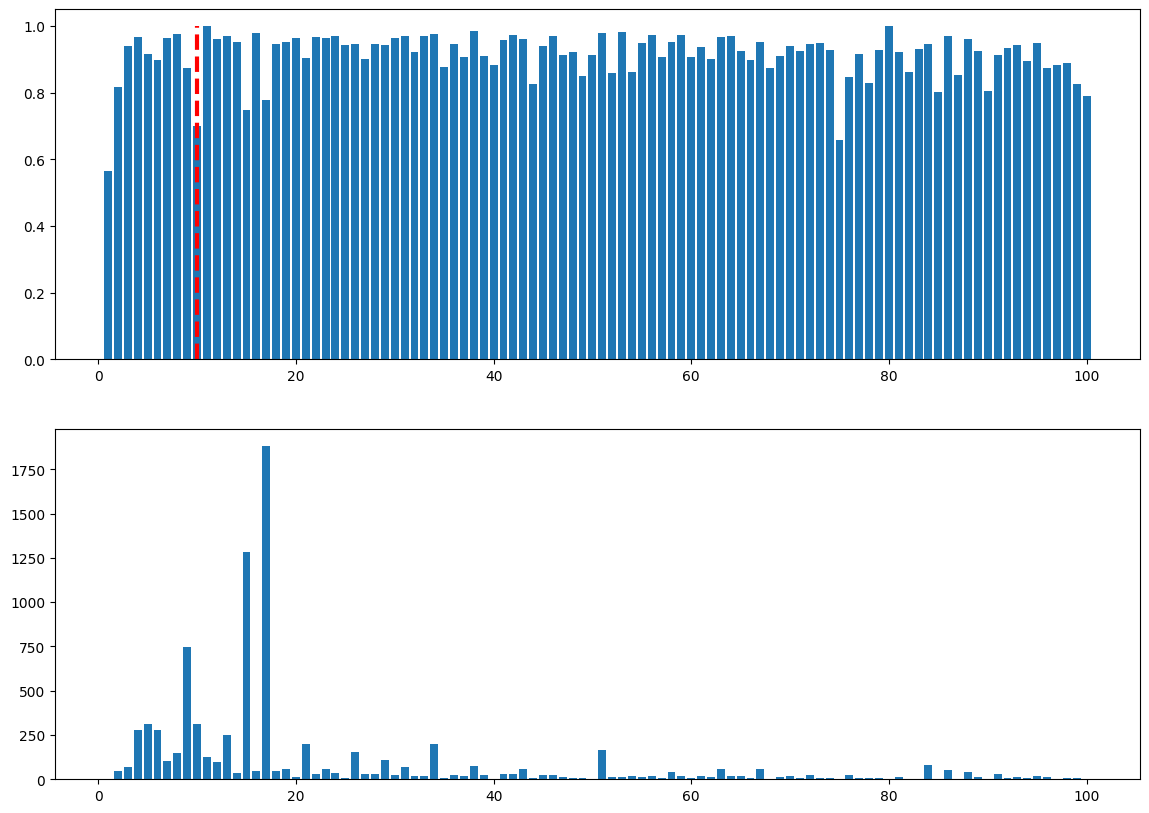

In [12]:
test_bin = 10
cosine_similarity = np.array([1 - spatial.distance.cosine(bin_embedding_means[j], bin_embedding_means[test_bin]) for j in range(len(bin_embedding_means))])

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
xx=np.arange(1, 101)
axs[0].bar(xx, cosine_similarity)
axs[0].vlines(test_bin, 0, 1, color="red", linestyle="dashed", linewidth=3)
axs[1].bar(xx, bin_counts)
plt.show()


In [13]:
sample_embeddings

array([[ 0.07989536,  0.12384047, -0.1636759 , ...,  0.036359  ,
         0.14649582,  0.1374064 ],
       [ 0.1639837 ,  0.07115847, -0.10058896, ...,  0.0074725 ,
         0.11434105,  0.15755802],
       [ 0.13482374,  0.05351252, -0.1005853 , ...,  0.02041043,
         0.15807632,  0.21536829],
       ...,
       [ 0.11782839,  0.23570746, -0.14027147, ...,  0.11004623,
         0.21135157,  0.15916614],
       [-0.00804872,  0.11999168, -0.092035  , ...,  0.02212394,
         0.1590745 ,  0.17375109],
       [ 0.10331263,  0.15109035, -0.10275923, ...,  0.03868599,
         0.15535997,  0.13731268]], dtype=float32)

In [14]:
norm_bin_embedding_means = bin_embedding_means / np.linalg.norm(bin_embedding_means, axis=1, keepdims=True)

/tmp/ipykernel_51154/459451463.py:1: RuntimeWarning: invalid value encountered in divide
  norm_bin_embedding_means = bin_embedding_means / np.linalg.norm(bin_embedding_means, axis=1, keepdims=True)


In [15]:
cos_similarity_all = np.matmul(norm_bin_embedding_means, norm_bin_embedding_means.T)


In [16]:
cos_similarity_all.shape

(100, 100)

<Axes: >

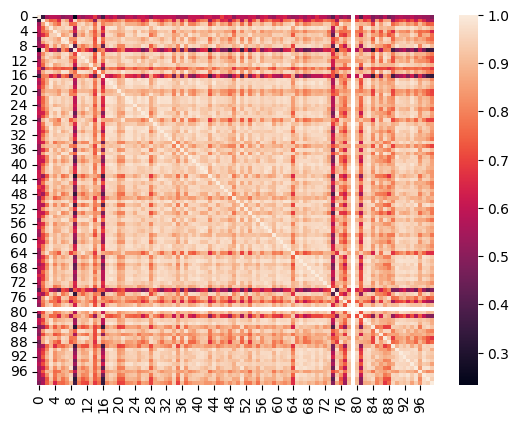

In [17]:
sns.heatmap(cos_similarity_all)

# Label smoothing 

In [22]:
from scipy.ndimage import gaussian_filter1d, convolve1d
from collections import Counter
from scipy.signal.windows import triang

def get_lds_kernel_window(kernel, ks, sigma=0.0):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


def get_loss_weights(target_labels, n_bins, kernel, ks, sigma):
    bins = np.linspace(0, 1.0, n_bins+1)
    bin_index_per_label = np.digitize(target_labels, bins)
    bin_index_per_label -= 1
    num_samples_per_bin = dict(Counter(bin_index_per_label))
    emp_label_dist = np.array([num_samples_per_bin.get(i, 0) for i in range(n_bins)])
    
    lds_kernel_window = get_lds_kernel_window(kernel=kernel, ks=ks, sigma=sigma)
    eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')
    weight_per_bin = np.array([np.float32(1 / x) for x in eff_label_dist])
    weight_per_bin = weight_per_bin/np.sum(weight_per_bin)
    return bins, weight_per_bin, emp_label_dist, eff_label_dist

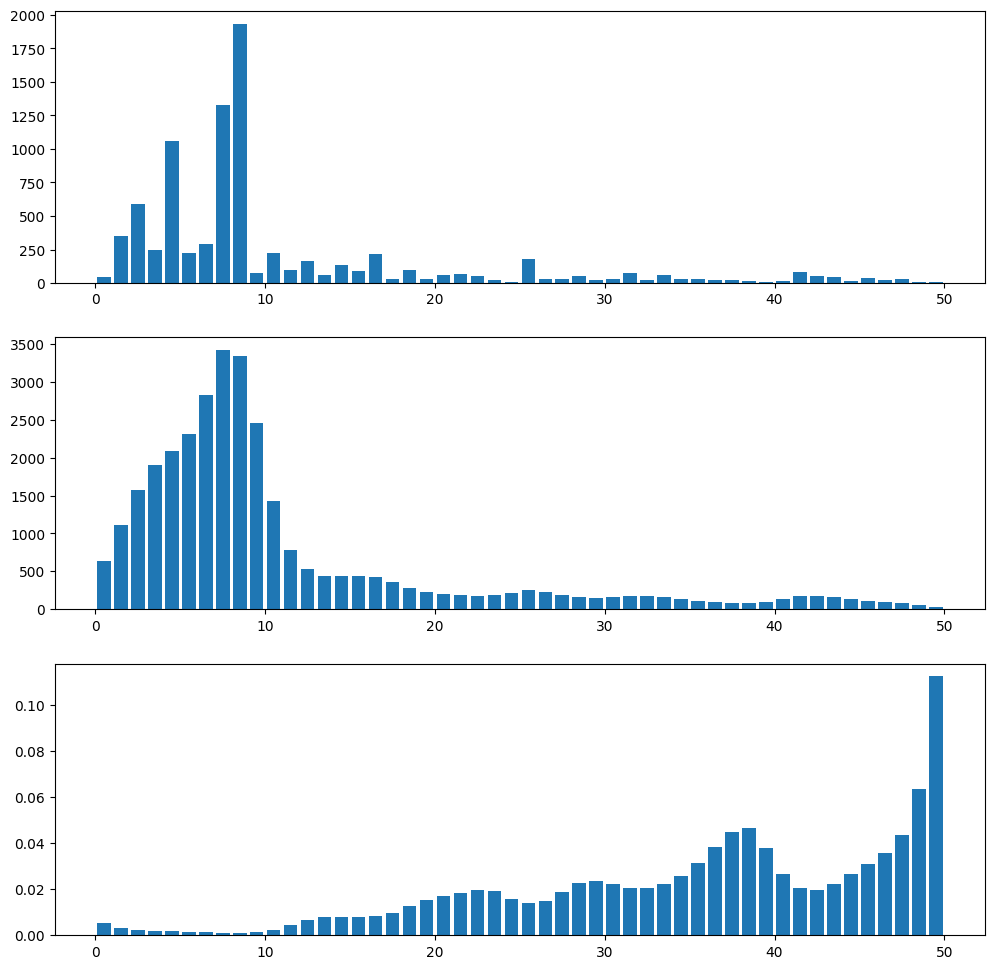

In [31]:
nbins = 50
bins, weight_per_bin, emp_label_dist, eff_label_dist = get_loss_weights(iedb_df["Distr. Mean"], nbins, "gaussian", 11, 1.5)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].bar(np.arange(nbins)+0.5, emp_label_dist)
axs[1].bar(np.arange(nbins)+0.5, eff_label_dist)
axs[2].bar(np.arange(nbins)+0.5, weight_per_bin)

plt.show()




In [30]:
(iedb_df["Distr. Mean"]>0.5).mean()

0.09414969208905732

(array([11.,  3.,  0.,  3.,  2.,  1.,  3.,  5.,  3.,  2.,  4.,  2.,  2.,
         2.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.00138544, 0.00373118, 0.00607692, 0.00842267, 0.01076841,
        0.01311415, 0.0154599 , 0.01780564, 0.02015138, 0.02249713,
        0.02484287, 0.02718862, 0.02953436, 0.0318801 , 0.03422585,
        0.03657159, 0.03891733, 0.04126308, 0.04360882, 0.04595456,
        0.04830031, 0.05064605, 0.0529918 , 0.05533754, 0.05768328,
        0.06002903, 0.06237477, 0.06472051, 0.06706626, 0.069412  ,
        0.07175774, 0.07410349, 0.07644923, 0.07879497, 0.08114072,
        0.08348646, 0.08583221, 0.08817795, 0.09052369, 0.09286944,
        0.09521518]),
 <BarContainer object of 40 artists>)

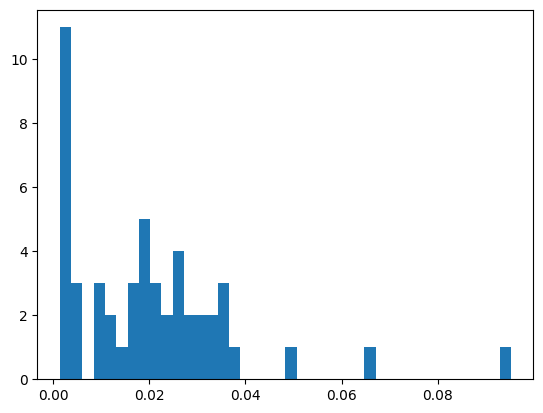

In [20]:
plt.hist(weight_per_bin, 40)

In [21]:

# calculate empirical (original) label distribution: [Nb,]
# "Nb" is the number of bins
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = np.array([num_samples_of_bins.get(i, 0) for i in range(Nb)])
emp_label_dist = emp_label_dist/np.sum(emp_label_dist)

# lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
lds_kernel_window = get_lds_kernel_window(kernel='triang', ks=7, sigma=4)
# calculate effective label distribution: [Nb,]
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

NameError: name 'bin_index_per_label' is not defined

In [ ]:
lds_kernel_window

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 9))

axs[0].bar(np.arange(100)+0.5, emp_label_dist)
axs[1].bar(np.arange(100)+0.5, eff_label_dist)

plt.show()

In [ ]:
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]

In [ ]:
np.max(weights)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(weights, bins=40)
ax.set_yscale("log")
plt.show()